In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve,RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

In [3]:
plt.rcParams["figure.figsize"] = (15,9)
sns.set_theme()
RANDOM_SEED = 0

In [4]:
#Helper functions

def barplot_target_feature(df,target_name,feature_name):
    """
    Create a 100% stacked bar plot showing target distribution across feature categories.
    
    Parameters:
    df : pandas.DataFrame
        DataFrame with feature categories as index and target percentages as columns (pd.crosstab).
        Values should already be in percentage format.
    target_name : str
        Name of the target variable for y-axis label.
    feature_name : str
        Name of the feature variable for x-axis label and plot title.
    
    Returns: None
        Displays the stacked bar plot.
    """
    plt.figure()
    df.plot(kind="bar",stacked=True,figsize=(8,6),color=["tomato","teal"])
    plt.title(f"Response based on {feature_name} distribution")
    plt.xlabel(feature_name)
    plt.ylabel(target_name + " %")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_cm(y_true,y_pred,title="Confusion Matrix",show_precision_recall = False):
    """
    Plot a confusion matrix heatmap with optional precision and recall metrics.
    
    Parameters:
    y_true : array-like
        True binary labels.
    y_pred : array-like
        Predicted binary labels.
    title : str, default="Confusion Matrix"
        Title for the confusion matrix plot.
    show_precision_recall : bool, default=False
        If True, displays precision and recall values below the heatmap.
    
    Returns: None
    """
    cm = confusion_matrix(y_true,y_pred)
    df_cm = pd.DataFrame(cm,
                        index = ["Negative","Positive"],
                        columns = ["Predicted Negative","Predicted Positive"])
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm,annot=True,fmt="d",cmap="crest")
    plt.title(title)
    if show_precision_recall:
        plt.text(0,-0.1,f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.2f}")
        plt.text(1,-0.1,f"Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.2f}")
    
def report_result(model,X,y,graph_title = "Train set"):
    """
    Prints classification report and displays ROC curve and confusion matrix plots.
    
    Parameters:
    model : sklearn estimator
        Trained machine learning model with predict() and predict_proba() methods.
    X : array-like or pandas.DataFrame
        Feature matrix for evaluation.
    y : array-like
        True binary labels.
    graph_title : str, default="Train set"
        Title prefix for all generated plots and printed output.
    
    Returns: None
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    print(graph_title + " Evaluation")
    print(classification_report(y,y_pred))
    RocCurveDisplay.from_estimator(model,X,y)
    plt.title("ROC Curve "+ graph_title)
    plot_cm(y,y_pred,title= f"{graph_title} Confusion Matrix",show_precision_recall = True)



### PROJECT OBJECTIVE

# Step 1 - Data Pre-Processing and EDA

In [5]:
# We start by importing the dataset and visualizing the main characteristics
url = ("https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv")
data = pd.read_csv(url)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [6]:
# Check for missing values
data.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
#The dataset consists of 381.109 and 12 columns, there are no missing values

In [8]:
# We can drop the "id" column since it will not add any information to our ML Model
data = data.drop("id", axis=1)

In [9]:
data.select_dtypes(include=[np.number])

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,44,1,28.0,0,40454.0,26.0,217,1
1,76,1,3.0,0,33536.0,26.0,183,0
2,47,1,28.0,0,38294.0,26.0,27,1
3,21,1,11.0,1,28619.0,152.0,203,0
4,29,1,41.0,1,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...
381104,74,1,26.0,1,30170.0,26.0,88,0
381105,30,1,37.0,1,40016.0,152.0,131,0
381106,21,1,30.0,1,35118.0,160.0,161,0
381107,68,1,14.0,0,44617.0,124.0,74,0


In [10]:
data.select_dtypes(include=["object"])

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
381104,Male,1-2 Year,No
381105,Male,< 1 Year,No
381106,Male,< 1 Year,No
381107,Female,> 2 Years,Yes


In [11]:
# List numerical features
numerical_features = list(data.select_dtypes(include=[np.number]).drop(columns=["Response"],axis=1))
print(f"Numerical features count: {len(numerical_features)}")
numerical_features

Numerical features count: 7


['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage']

In [12]:
# The Dataset has 7 numerical features:
#    - Age, Annual_Premium, Vintage are in fact 3 numerical variables, int or float. 
#    - Driving_License and Previously_Insured are boolean data
#    - Region_Code, Policy_Sales_Channel are basically not numerical data type, these are categorical data represented by numbers. 
#    We will encode and transform these features in order to create a proper model.

In [13]:
# List categorical features
categorical_features = list(data.select_dtypes(include=["object"]))
print(f"Categorical features count: {len(categorical_features)}")
categorical_features

Categorical features count: 3


['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [14]:
# The Dataset has 3 categorical features:
#    - Gender has 2 unique values that are independent one from each other, we can use one hot encoding
#    - Vehichle Age has a natural order, we can use OrdinalEncoding
#    - Vehicle Damage values are boolean, we can use label encoding
#    We will encode and transform these features in order to create a proper model.

In [15]:
## Target Analysis

response_frequency = data["Response"].value_counts()
response_percentage = data["Response"].value_counts(normalize=True) * 100

print(f"No purchase (0): {response_frequency[0]}, {response_percentage[0]:.1f}% of total clients")
print(f"Purchase (1): {response_frequency[1]}, {response_percentage[1]:.1f}% of total clients")

No purchase (0): 334399, 87.7% of total clients
Purchase (1): 46710, 12.3% of total clients


In [16]:
# The target class is unbalanced towards the NO purchase class

<Figure size 1500x900 with 0 Axes>

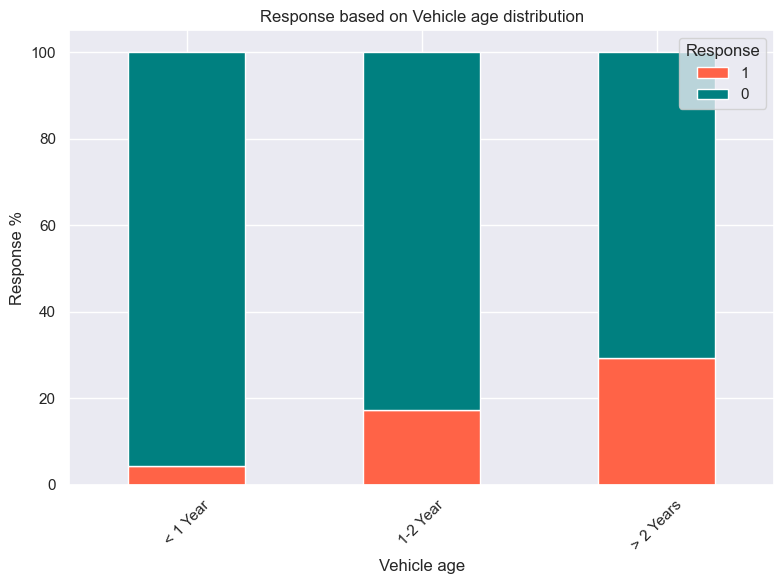

<Figure size 1500x900 with 0 Axes>

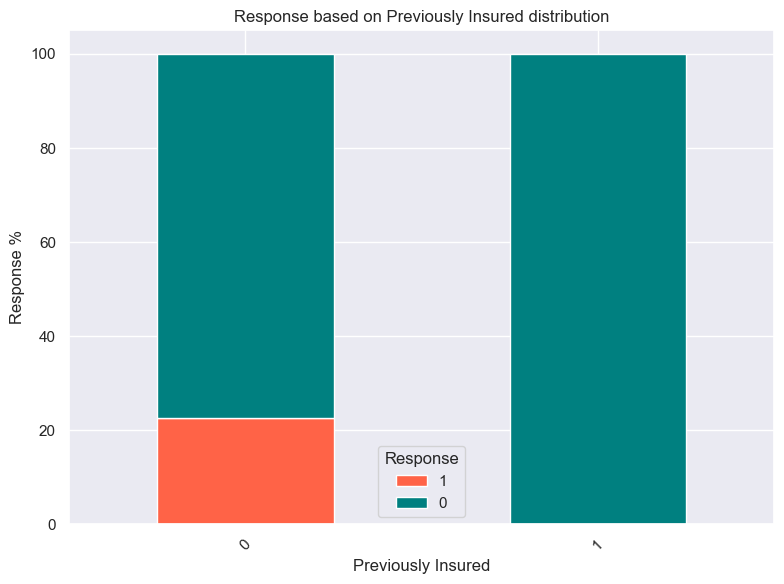

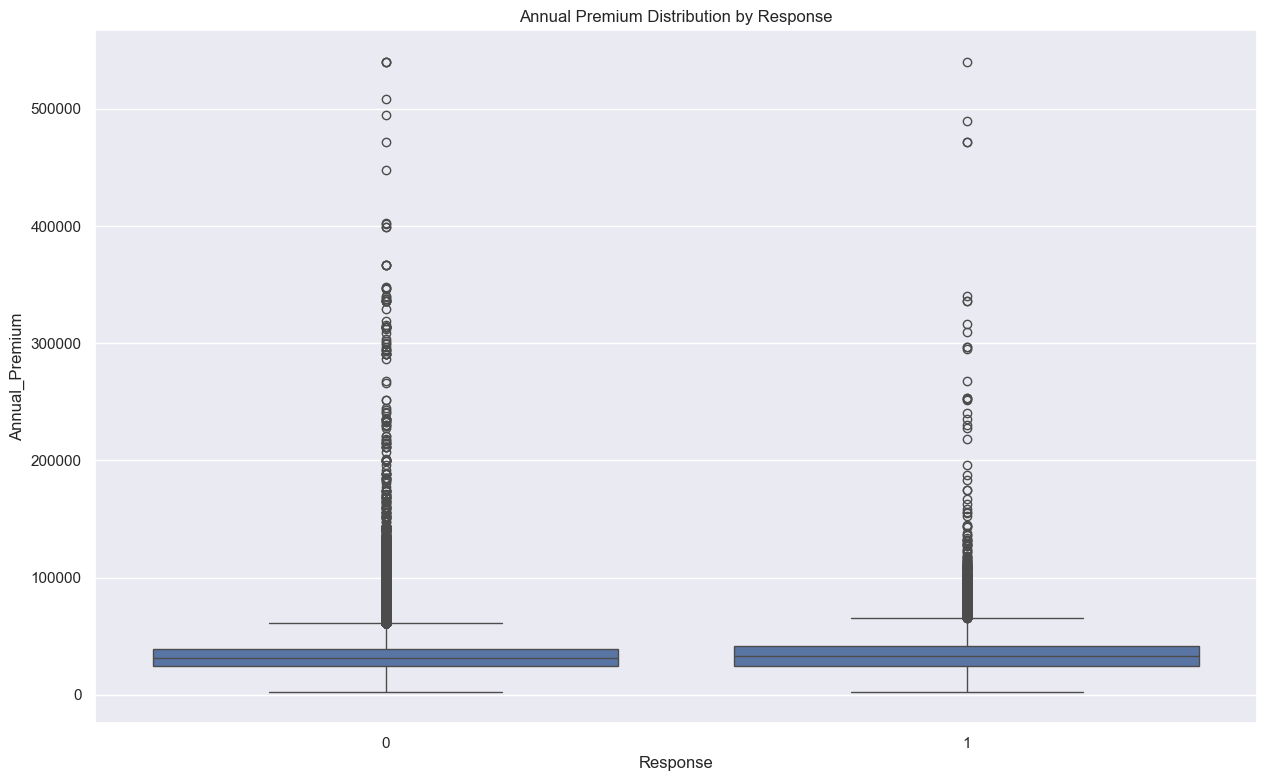

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,334399.0,30419.160276,16998.293197,2630.0,24351.0,31504.0,39120.0,540165.0
1,46710.0,31604.092742,18646.508040,2630.0,24868.0,33002.0,41297.0,540165.0


In [17]:
# Investigate relationship between the "Response" target and the three variables Annual Premium, Vehicle Age, Previously Insured
vehicle_age_response_df = (pd.crosstab(data['Vehicle_Age'],data['Response'], normalize='index') * 100).reindex(["< 1 Year","1-2 Year","> 2 Years"])[[1,0]]
barplot_target_feature(vehicle_age_response_df,"Response","Vehicle age")
previouslyinsured_response_df = (pd.crosstab(data['Previously_Insured'], data['Response'], normalize='index') * 100)[[1,0]]
barplot_target_feature(previouslyinsured_response_df,"Response","Previously Insured")

plt.figure()
sns.boxplot(data=data, x='Response', y='Annual_Premium')
plt.title('Annual Premium Distribution by Response')
plt.show()

data.groupby('Response')['Annual_Premium'].describe()

### Summary of Key Findings from EDA
Strongest Predictors Identified:
   - Previously_Insured: Customers without vehicle insurance are more likely to buy
   - Vehicle_Age: Customers with older vehicles (>2 years) have higher purchase rates
   - Annual_Premium: Shows weak relationship with purchase decision, with a pretty similar distribution 
 of the annual premium between the target value of 0 and 1

# Step 2 - Features Encoding

In [18]:
# Features Encoding - One Hot Encoding for Gender, we also directly drop one of the two genders since the negation of one equals the other one
data  = pd.get_dummies(data,columns=["Gender"],prefix="Gender_",drop_first=True)
# Features Encoding - Ordinal Encoding for Vehicle_Age
Vehicle_age_mapping = {"< 1 Year":0,"1-2 Year":1,"> 2 Years":2}
data["Vehicle_Age"] = data["Vehicle_Age"].map(Vehicle_age_mapping)
# Features Encoding - Label Encoding for Vehicle_Damage
le = LabelEncoder()
data["Vehicle_Damage"] = le.fit_transform(data["Vehicle_Damage"])

In [19]:
X = data.drop(["Response"],axis=1)
y  = data["Response"]
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = RANDOM_SEED,stratify=y)
X.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gender__Male
0,44,1,28.0,0,2,1,40454.0,26.0,217,True
1,76,1,3.0,0,1,0,33536.0,26.0,183,True
2,47,1,28.0,0,2,1,38294.0,26.0,27,True
3,21,1,11.0,1,0,0,28619.0,152.0,203,True
4,29,1,41.0,1,0,0,27496.0,152.0,39,False


In [20]:
# Target encoding for "Region_Code"
region_target_means = y_train.groupby(X_train["Region_Code"]).mean()
# Handling misssing values that come from missing codes in the train set

In [21]:
# Now we can apply the encoding to the train set
X_train["Region_Code_encoded"] = X_train["Region_Code"].map(region_target_means)
X_test["Region_Code_encoded"] = X_test["Region_Code"].map(region_target_means)
X_train

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gender__Male,Region_Code_encoded
316624,25,1,14.0,0,0,1,23791.0,152.0,299,False,0.090003
126373,23,1,46.0,1,0,0,36820.0,152.0,80,False,0.103143
30736,22,1,32.0,0,0,1,44095.0,152.0,225,True,0.081318
156924,21,1,30.0,1,0,0,35028.0,160.0,13,False,0.074126
86112,23,1,8.0,1,0,0,50633.0,152.0,180,False,0.095500
...,...,...,...,...,...,...,...,...,...,...,...
56560,32,1,39.0,0,0,1,61885.0,154.0,67,False,0.125540
238783,59,1,33.0,0,1,1,30886.0,26.0,135,True,0.096404
142476,57,1,8.0,1,1,0,36004.0,26.0,268,True,0.095500
209594,24,1,29.0,1,0,0,24901.0,151.0,102,False,0.120972


In [22]:
print("NaN in the test_set for Region_Code:", X_test['Region_Code_encoded'].isna().sum())
if X_test['Region_Code_encoded'].isna().sum() > 0:
    global_mean = y_train.mean()
    X_test['Region_Code_encoded'].fillna(global_mean, inplace=True)

NaN in the test_set for Region_Code: 0


In [23]:
# Target encoding for "Sales_Channel"
Sales_Channels_means = y_train.groupby(X_train["Policy_Sales_Channel"]).mean()

In [24]:
# Train set
X_train['Policy_Sales_Channel_encoded'] = X_train['Policy_Sales_Channel'].map(Sales_Channels_means)

# Test set
X_test['Policy_Sales_Channel_encoded'] = X_test['Policy_Sales_Channel'].map(Sales_Channels_means)

In [25]:
# Handling misssing values that come from missing codes in the train set
print("NaN in the test_set for Policy_Sales_Channel:", X_test['Policy_Sales_Channel_encoded'].isna().sum())

NaN in the test_set for Policy_Sales_Channel: 2


In [26]:
if X_test['Policy_Sales_Channel_encoded'].isna().sum() > 0:
    global_mean = y_train.mean()
    X_test['Policy_Sales_Channel_encoded'].fillna(global_mean, inplace=True)

C:\Users\GiulioZerilli\AppData\Local\Temp\ipykernel_8708\2770762978.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Policy_Sales_Channel_encoded'].fillna(global_mean, inplace=True)


In [27]:
columns_to_drop = ['Region_Code', 'Policy_Sales_Channel']
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [28]:
print("Data types, last check before model creation:")
print(X_train.dtypes)
print("\nCheck for NaN:")
print(X_train.isna().sum())

Data types, last check before model creation:
Age                               int64
Driving_License                   int64
Previously_Insured                int64
Vehicle_Age                       int64
Vehicle_Damage                    int32
Annual_Premium                  float64
Vintage                           int64
Gender__Male                       bool
Region_Code_encoded             float64
Policy_Sales_Channel_encoded    float64
dtype: object

Check for NaN:
Age                             0
Driving_License                 0
Previously_Insured              0
Vehicle_Age                     0
Vehicle_Damage                  0
Annual_Premium                  0
Vintage                         0
Gender__Male                    0
Region_Code_encoded             0
Policy_Sales_Channel_encoded    0
dtype: int64


# STEP 3 Model Creation

In [29]:
ss = StandardScaler()
# Fit only on train set
ss.fit(X_train[['Age', 'Annual_Premium', 'Vintage',"Region_Code_encoded","Policy_Sales_Channel_encoded"]])
# Transform on train and test
X_train[['Age', 'Annual_Premium', 'Vintage',"Region_Code_encoded","Policy_Sales_Channel_encoded"]] = ss.transform(X_train[['Age', 'Annual_Premium', 'Vintage',"Region_Code_encoded","Policy_Sales_Channel_encoded"]])

X_test[['Age', 'Annual_Premium', 'Vintage',"Region_Code_encoded","Policy_Sales_Channel_encoded"]] = ss.transform(X_test[['Age', 'Annual_Premium', 'Vintage',"Region_Code_encoded","Policy_Sales_Channel_encoded"]])
X_train

,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Gender__Male,Region_Code_encoded,Policy_Sales_Channel_encoded
316624,-0.891500,1,0,0,1,-0.394147,1.728266,False,-0.721195,-1.088329
126373,-1.020391,1,1,0,0,0.365819,-0.887715,False,-0.430163,-1.088329
30736,-1.084837,1,0,0,1,0.790161,0.844327,True,-0.913575,-1.088329
156924,-1.149282,1,1,0,0,0.261294,-1.688038,False,-1.072863,-1.158293
86112,-1.020391,1,1,0,0,1.171515,0.306797,False,-0.599443,-1.088329
...,...,...,...,...,...,...,...,...,...,...
56560,-0.440381,1,0,0,1,1.827830,-1.043002,False,0.065923,1.410084
238783,1.299649,1,0,1,1,0.019696,-0.230734,True,-0.579425,0.892904
142476,1.170758,1,1,1,0,0.318223,1.357967,True,-0.599443,0.892904
209594,-0.955946,1,1,0,0,-0.329402,-0.624923,False,-0.035252,-1.089329


In [30]:
lr = LogisticRegression(class_weight = "balanced")
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

Train set Evaluation
              precision    recall  f1-score   support

           0       0.99      0.65      0.79    234079
           1       0.27      0.93      0.42     32697

    accuracy                           0.69    266776
   macro avg       0.63      0.79      0.60    266776
weighted avg       0.90      0.69      0.74    266776

Test set Evaluation
              precision    recall  f1-score   support

           0       0.98      0.66      0.79    100320
           1       0.27      0.93      0.42     14013

    accuracy                           0.69    114333
   macro avg       0.63      0.79      0.61    114333
weighted avg       0.90      0.69      0.74    114333



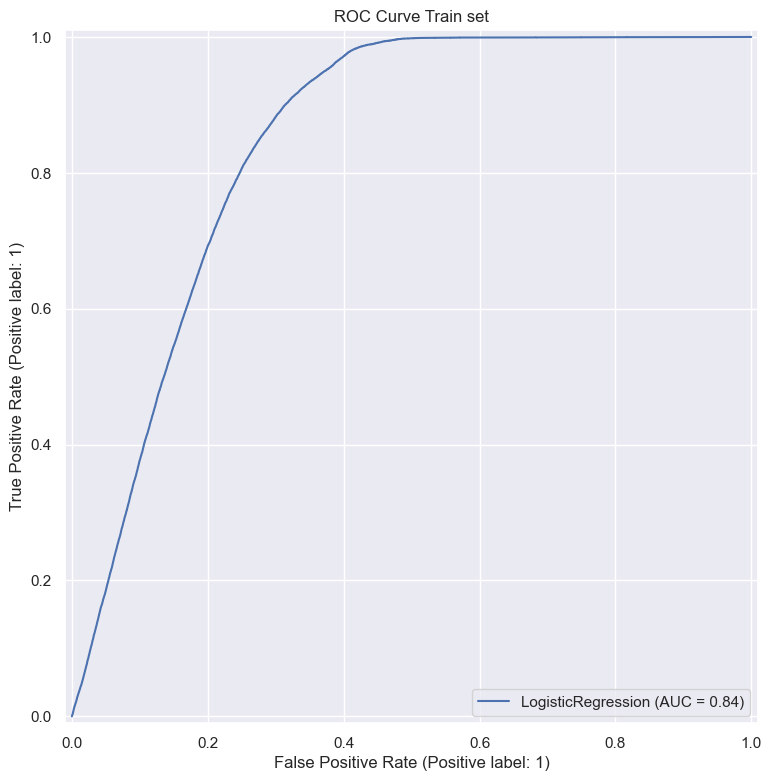

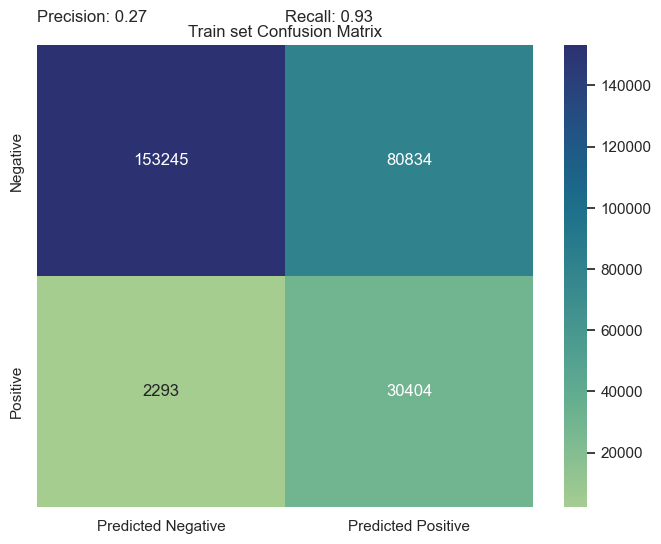

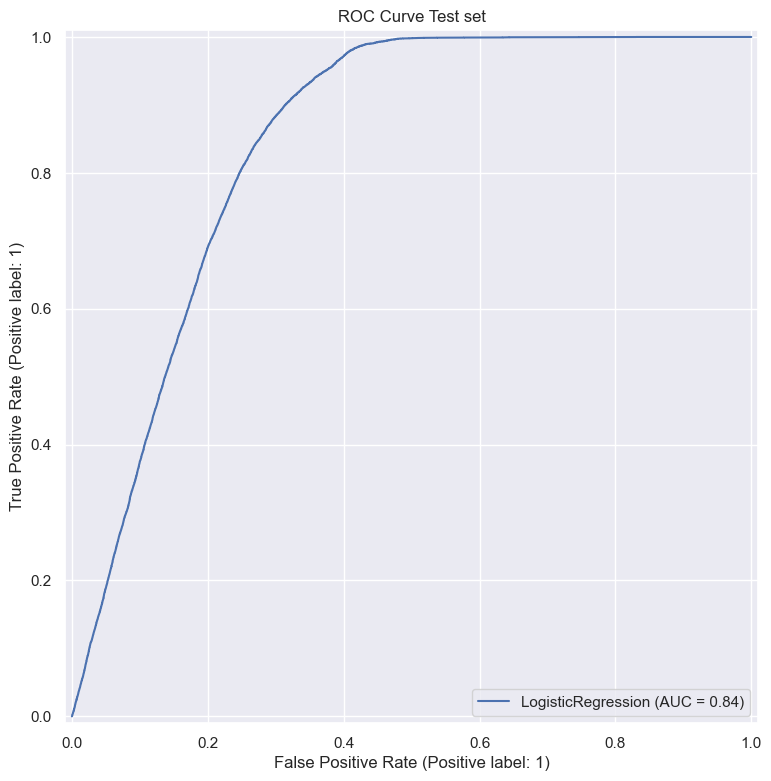

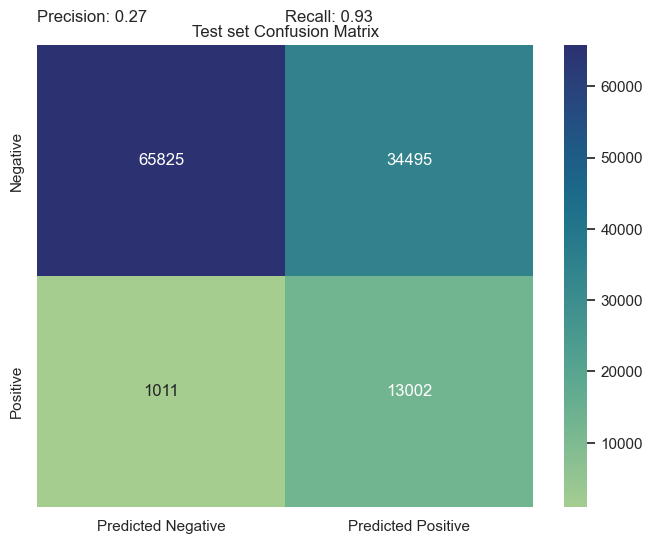

In [31]:
report_result(lr,X_train,y_train)
report_result(lr,X_test,y_test,graph_title="Test set")

In [32]:
# Cross Validation 
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

cv_results = cross_validate(pipeline, X, y, cv=5, scoring=['precision', 'recall',"f1"])
print(cv_results)


{'fit_time': array([0.8072114 , 0.88919973, 0.859164  , 1.00358605, 0.90334988]), 'score_time': array([0.20606613, 0.15006018, 0.21794224, 0.15340233, 0.17560363]), 'test_precision': array([0.25036338, 0.25017137, 0.24993133, 0.25104233, 0.25105822]), 'test_recall': array([0.97719974, 0.97666453, 0.97398844, 0.97323914, 0.97773496]), 'test_f1': array([0.39860277, 0.39831489, 0.39778788, 0.3991308 , 0.3995276 ])}


In [33]:
print(f"Mean precision across 5 fold validation: {cv_results["test_precision"].mean():.2f} ± {cv_results["test_precision"].std():.3f}  ")
print(f"Mean recall across 5 fold validation: {cv_results["test_recall"].mean():.2f} ± {cv_results["test_recall"].std():.3f}  ")
print(f"Mean f1_score across 5 fold validation: {cv_results["test_f1"].mean():.2f} ± {cv_results["test_f1"].std():.3f}  ")

Mean precision across 5 fold validation: 0.25 ± 0.000  
Mean recall across 5 fold validation: 0.98 ± 0.002  
Mean f1_score across 5 fold validation: 0.40 ± 0.001  


### STEP 4 - OVERSAMPLING AND UNDERSAMPLING

In [34]:
smote = SMOTE(random_state=RANDOM_SEED,sampling_strategy=0.5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote_series = pd.Series(y_train_smote)
response_frequency_oversampled = y_train_smote_series.value_counts()
response_percentage_oversampled = y_train_smote_series.value_counts(normalize=True) * 100

print(f"No purchase (0): {response_frequency_oversampled[0]}, {response_percentage_oversampled[0]:.1f}% of total clients")
print(f"Purchase (1): {response_frequency_oversampled[1]}, {response_percentage_oversampled[1]:.1f}% of total clients")

No purchase (0): 234079, 66.7% of total clients
Purchase (1): 117039, 33.3% of total clients


In [35]:
# Create the new model with the oversampled dataset
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)

LogisticRegression()

Train set Evaluation
              precision    recall  f1-score   support

           0       0.88      0.76      0.82    234079
           1       0.62      0.79      0.70    117039

    accuracy                           0.77    351118
   macro avg       0.75      0.78      0.76    351118
weighted avg       0.79      0.77      0.78    351118

Test set Evaluation
              precision    recall  f1-score   support

           0       0.96      0.76      0.85    100320
           1       0.31      0.78      0.45     14013

    accuracy                           0.76    114333
   macro avg       0.64      0.77      0.65    114333
weighted avg       0.88      0.76      0.80    114333



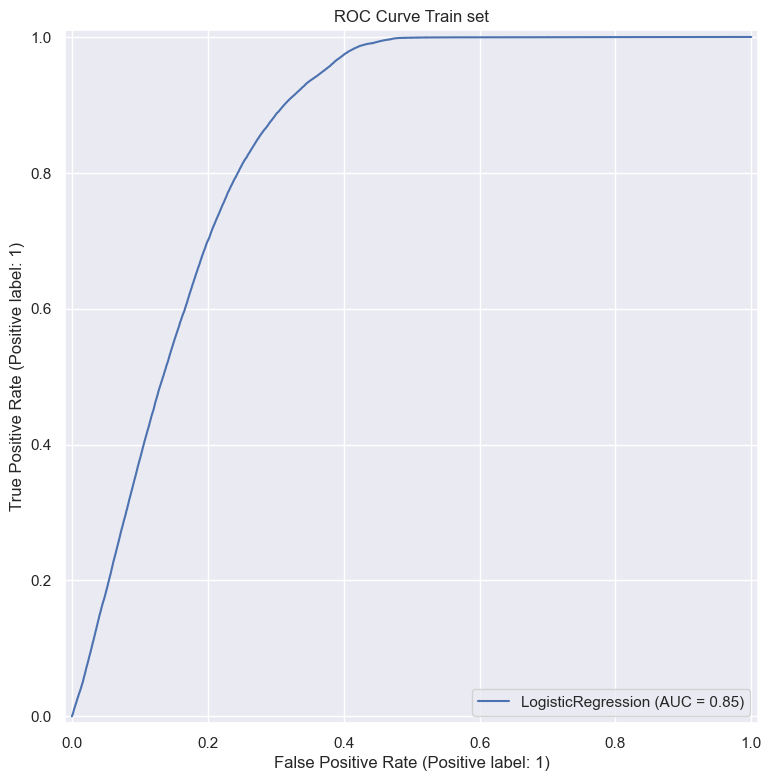

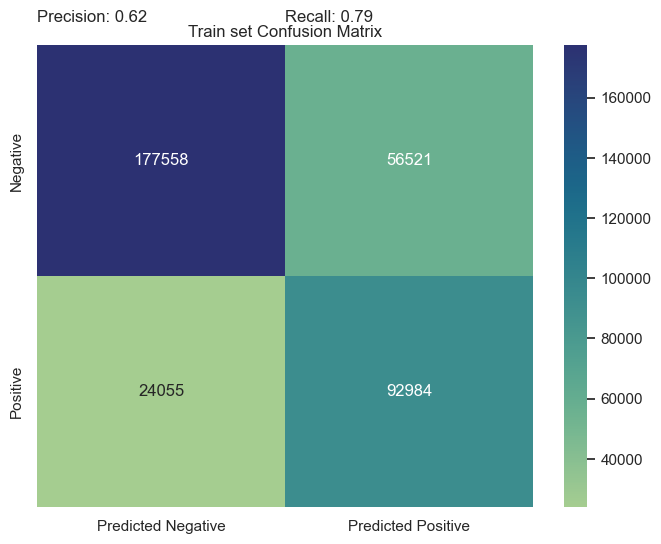

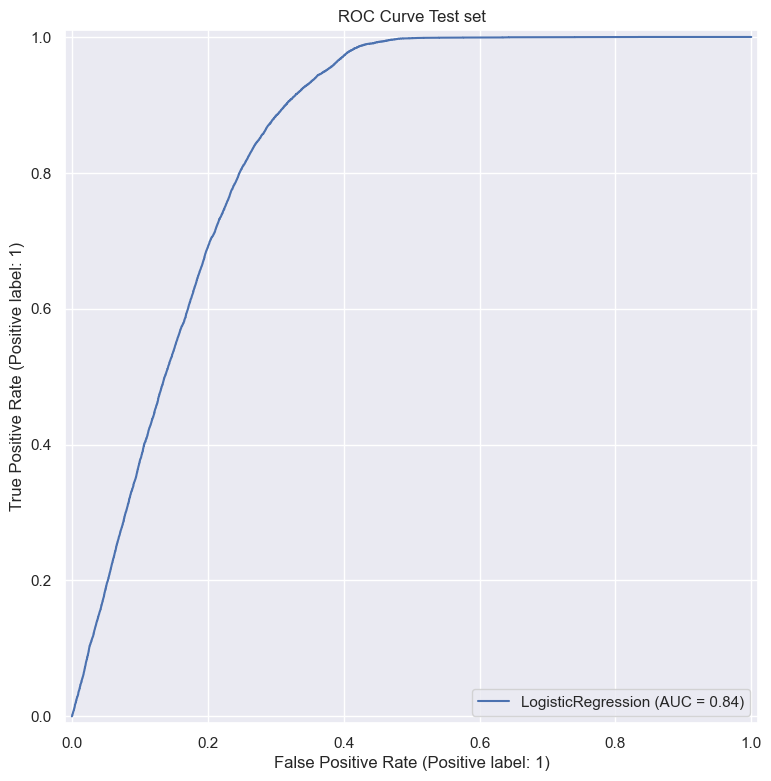

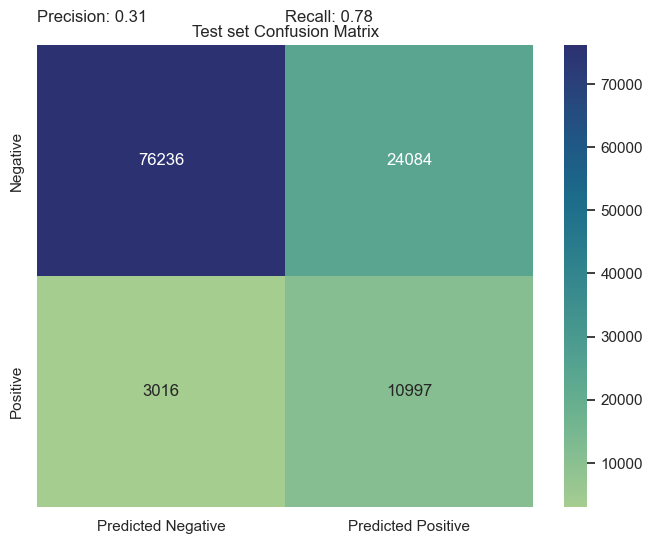

In [36]:
report_result(lr,X_train_smote,y_train_smote)
report_result(lr,X_test,y_test,graph_title="Test set")

### UNDERSAMPLING

In [37]:
undersampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Check class distribution after undersampling
y_train_under_series = pd.Series(y_train_under)
response_frequency_under = y_train_under_series.value_counts()
response_percentage_under = y_train_under_series.value_counts(normalize=True) * 100

print("After Random Undersampling:")
print(f"No purchase (0): {response_frequency_under[0]}, {response_percentage_under[0]:.1f}% of total clients")
print(f"Purchase (1): {response_frequency_under[1]}, {response_percentage_under[1]:.1f}% of total clients")

# Train model with undersampled data
lr_under = LogisticRegression()
lr_under.fit(X_train_under, y_train_under)

After Random Undersampling:
No purchase (0): 32697, 50.0% of total clients
Purchase (1): 32697, 50.0% of total clients


LogisticRegression()

Train set Evaluation
              precision    recall  f1-score   support

           0       0.91      0.65      0.76     32697
           1       0.73      0.93      0.82     32697

    accuracy                           0.79     65394
   macro avg       0.82      0.79      0.79     65394
weighted avg       0.82      0.79      0.79     65394

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100320
           1       0.27      0.93      0.42     14013

    accuracy                           0.69    114333
   macro avg       0.63      0.79      0.60    114333
weighted avg       0.90      0.69      0.74    114333



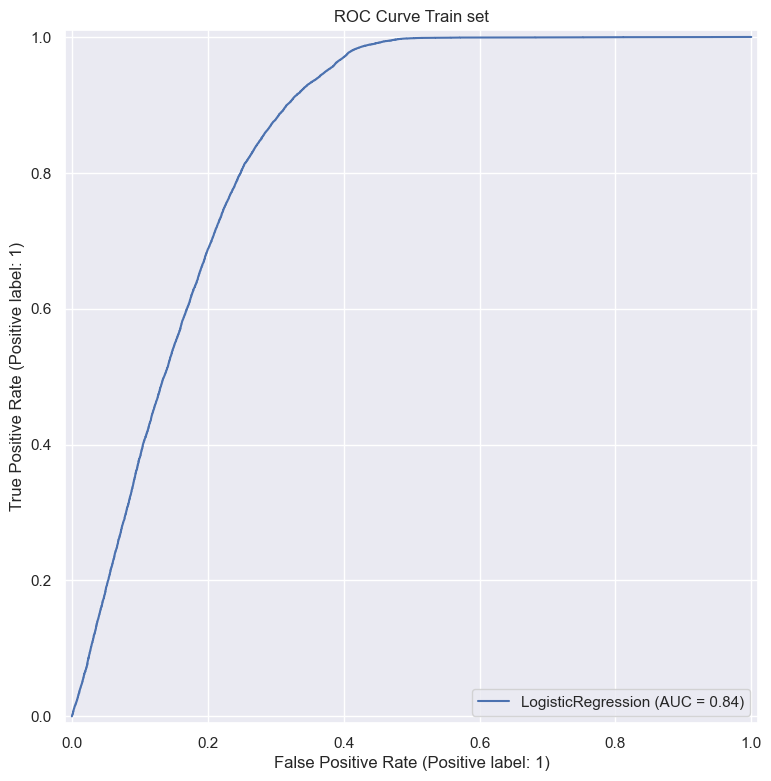

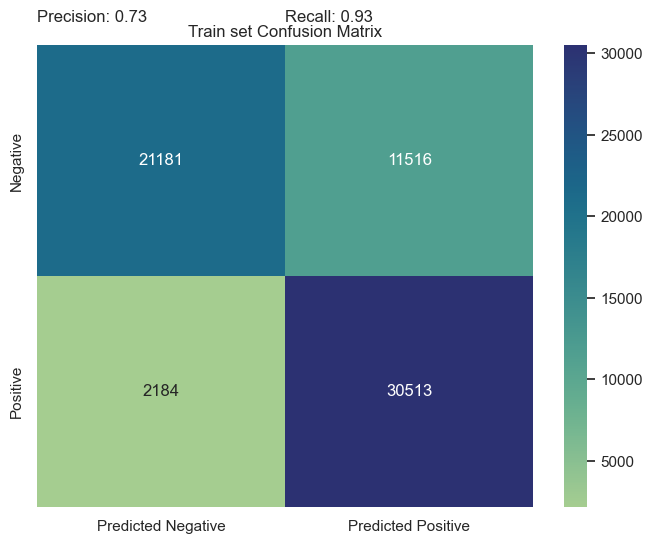

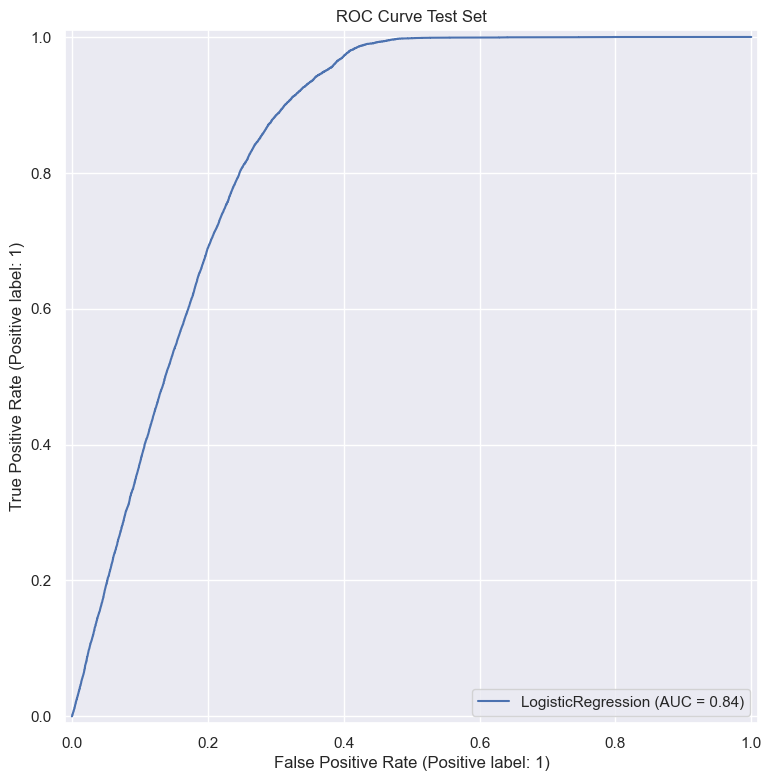

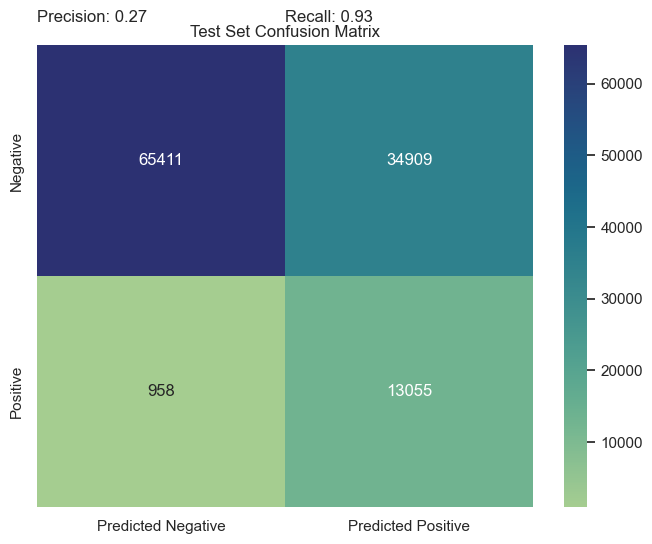

In [38]:
report_result(lr_under,X_train_under,y_train_under)
report_result(lr_under,X_test,y_test,graph_title="Test Set")

### STEP 5 - COMPARISON WITH DECISION TREE

In [39]:
dt = DecisionTreeClassifier(class_weight="balanced",random_state=RANDOM_SEED)
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

Train set Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234079
           1       1.00      1.00      1.00     32697

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.90      0.91      0.90    100320
           1       0.30      0.29      0.29     14013

    accuracy                           0.83    114333
   macro avg       0.60      0.60      0.60    114333
weighted avg       0.83      0.83      0.83    114333



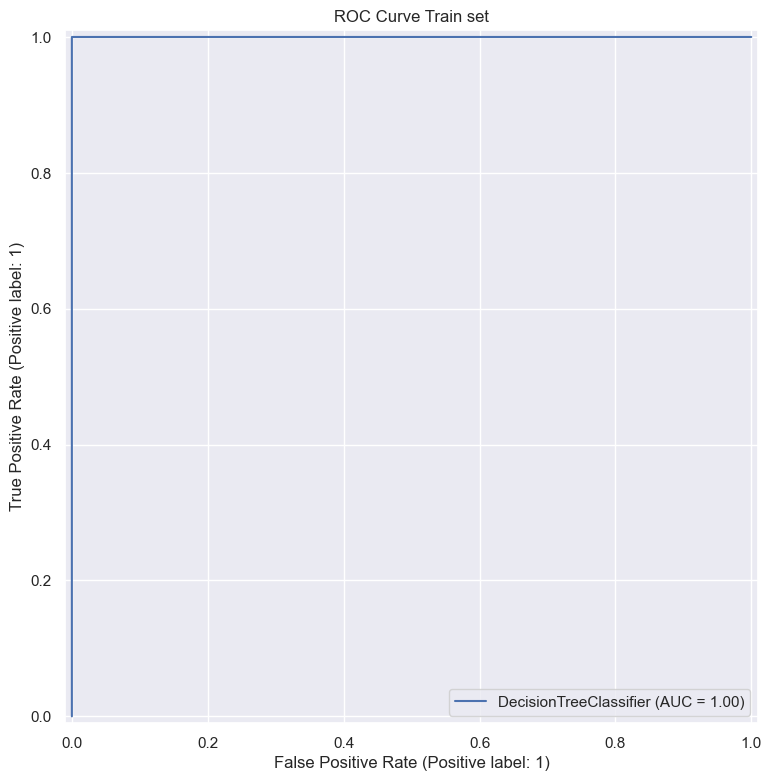

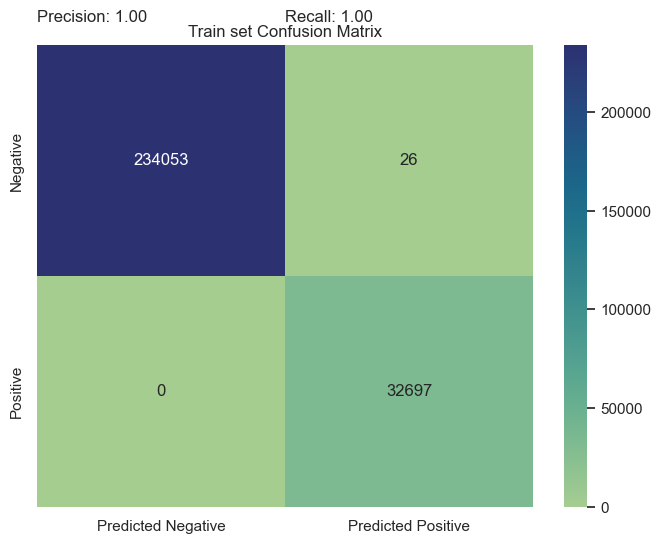

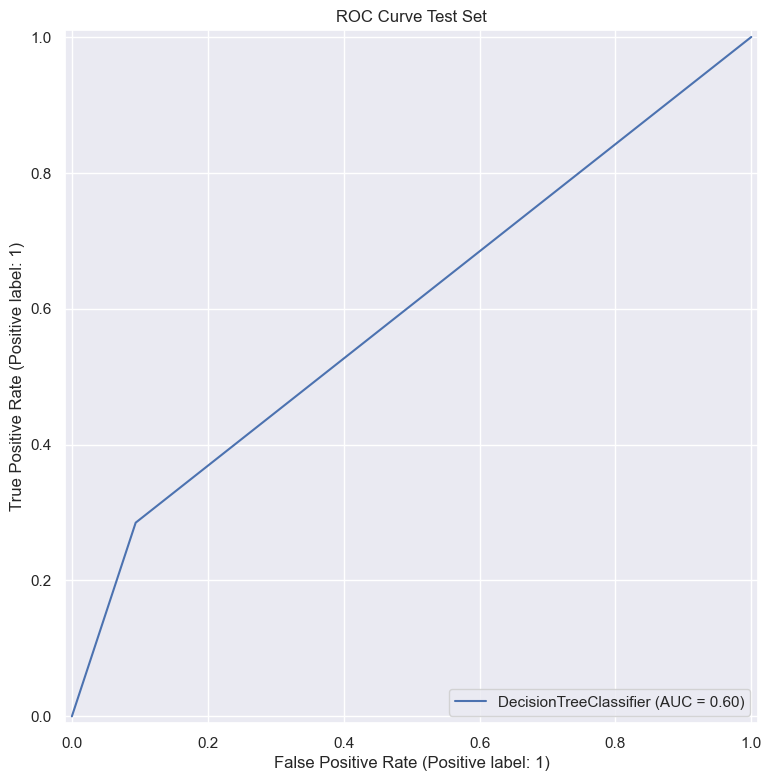

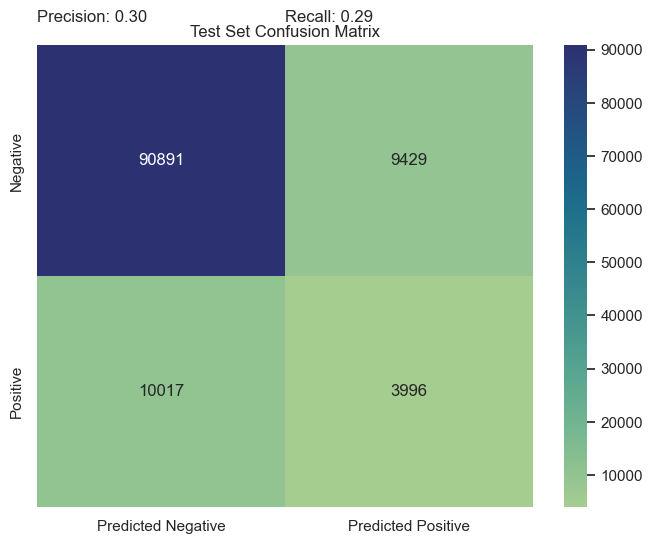

In [40]:
report_result(dt,X_train,y_train)
report_result(dt,X_test,y_test,graph_title="Test Set")

In [44]:
# Since the model is overfitting in the train set we reduce the max depth to 4. Ideally the best way to optimize it should be to perform a gridsearch
# with cross validation

dt_2 = DecisionTreeClassifier(class_weight="balanced",random_state=RANDOM_SEED,max_depth=4)
dt_2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=0)

Train set Evaluation
              precision    recall  f1-score   support

           0       0.99      0.61      0.76    234079
           1       0.26      0.97      0.41     32697

    accuracy                           0.66    266776
   macro avg       0.63      0.79      0.58    266776
weighted avg       0.90      0.66      0.72    266776

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.99      0.61      0.76    100320
           1       0.26      0.97      0.41     14013

    accuracy                           0.66    114333
   macro avg       0.63      0.79      0.58    114333
weighted avg       0.90      0.66      0.72    114333



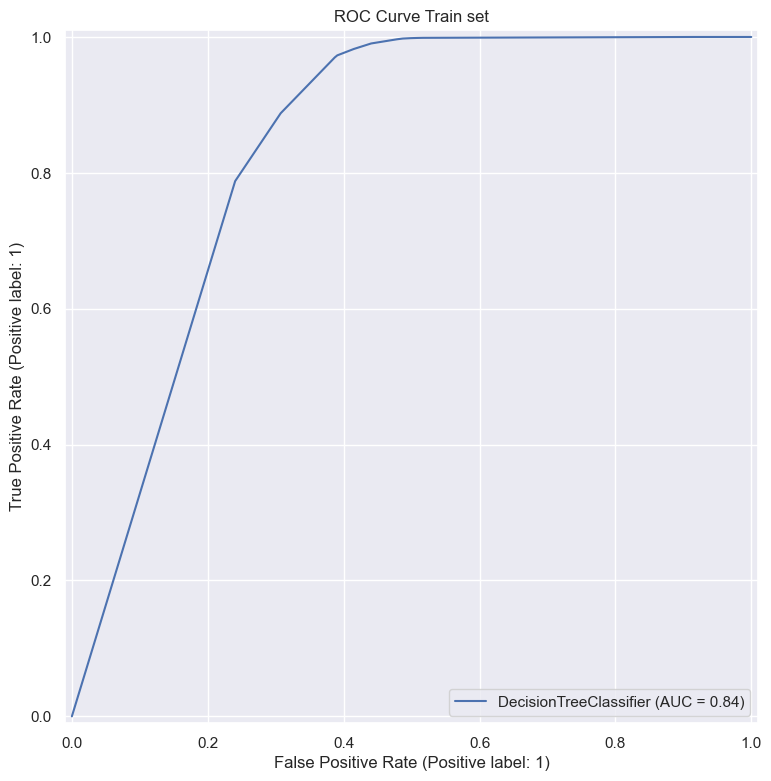

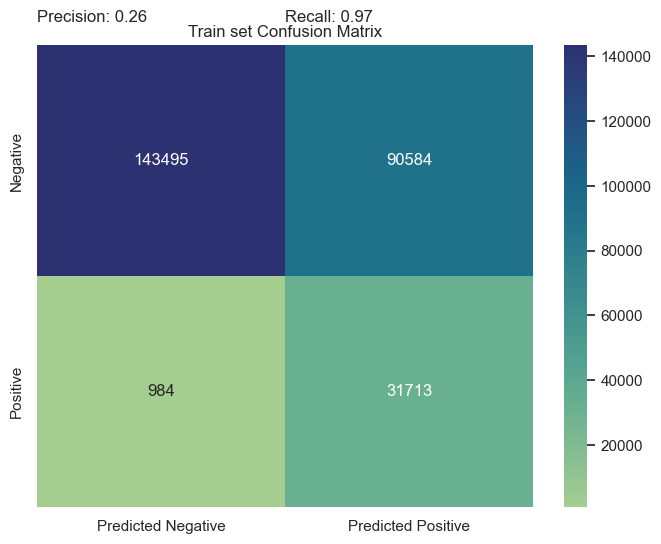

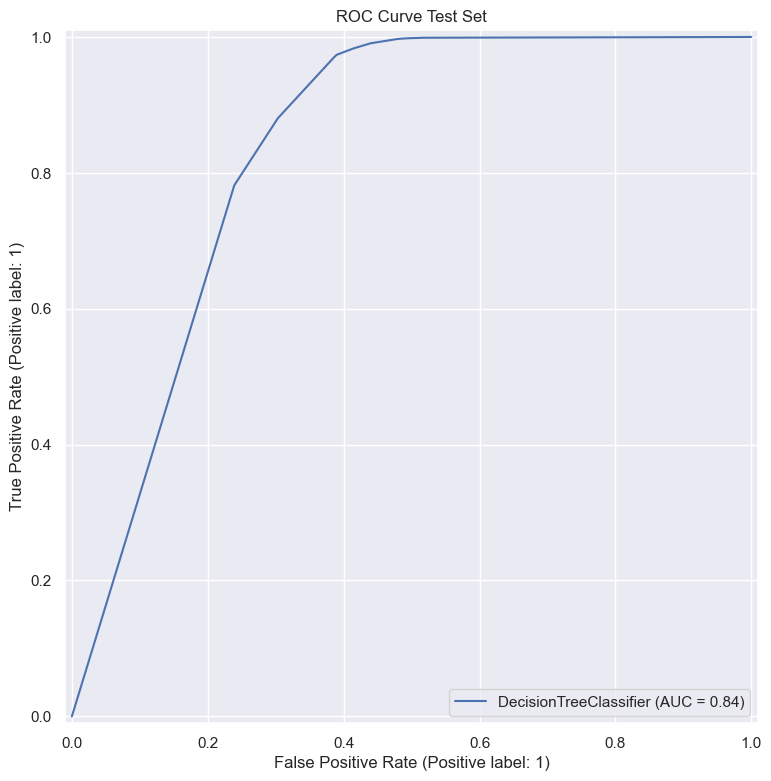

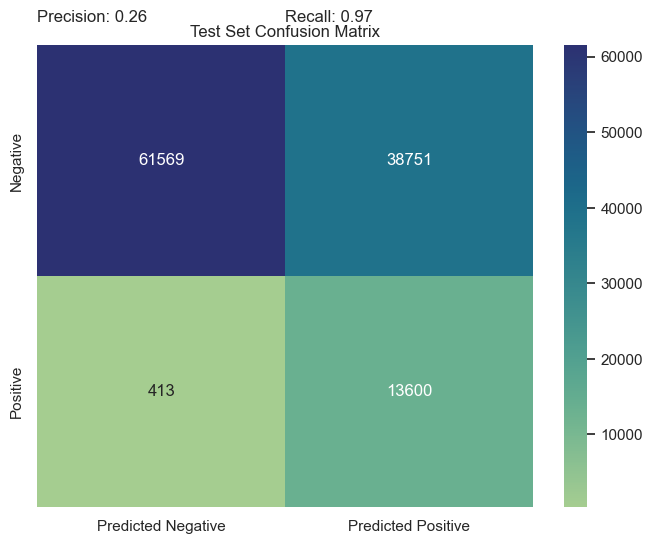

In [45]:
report_result(dt_2,X_train,y_train)
report_result(dt_2,X_test,y_test,graph_title="Test Set")

### Model Performance Summary
We evaluated 3 approaches to handle the severe class imbalance (88-12 distribution):
1) Class Weights:

Generalizes well with consistent train/test performance
Achieves 93% recall but only 27% precision (confirmed by CV: 97.4% recall, 25.0% precision)
Business implication: Captures almost all potential buyers but generates many false positives. The cost of pursuing false leads may be covered by the high capture rate of true buyers.

2) Oversampling/Undersampling (SMOTE + RandomUnderSampler):

Shows apparent improvement on training data (73% precision, 93% recall)
However, fails to generalize - test performance reverts to 27% precision
Indicates overfitting

The class-weighted approach is most reliable due to its consistent generalization. The 27% precision represents the realistic performance ceiling for this dataset. The choice between high recall (catch all buyers) vs. balanced precision-recall depends on business costs, losing potential buyers should cause more harm than chasing the not interested ones.

3) Comparison with decison tree:

In the first attempt the model overfitted on the train set, after reduction of max_depth hyperparameter perfomances similar to those of the logistic regression are obtained. 